In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

2024-01-29 12:09:22.670730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 12:09:22.670810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 12:09:22.741377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 12:09:22.947732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 12:09:24.457146: W tensorflow/compiler/tf2

In [32]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
batch_size = 16
image_height = 224
image_width = 224
data_dir = 'archive/cropped/train'

seed = 7
tf.random.set_seed(7)

In [8]:
training_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  validation_split = 0.2,
  subset = "training",
  image_size = (image_height, image_width),
  batch_size=batch_size)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
validation_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  shuffle = False,
  validation_split = 0.2,
  subset = "validation",
  image_size = (image_height, image_width),
  batch_size=batch_size)

Found 12000 files belonging to 120 classes.
Using 2400 files for validation.


In [6]:
testing_ds = keras.utils.image_dataset_from_directory(
'archive/cropped/test',
  shuffle = False,
  image_size = (image_height, image_width))

Found 8580 files belonging to 120 classes.


In [10]:
class_names = training_ds.class_names

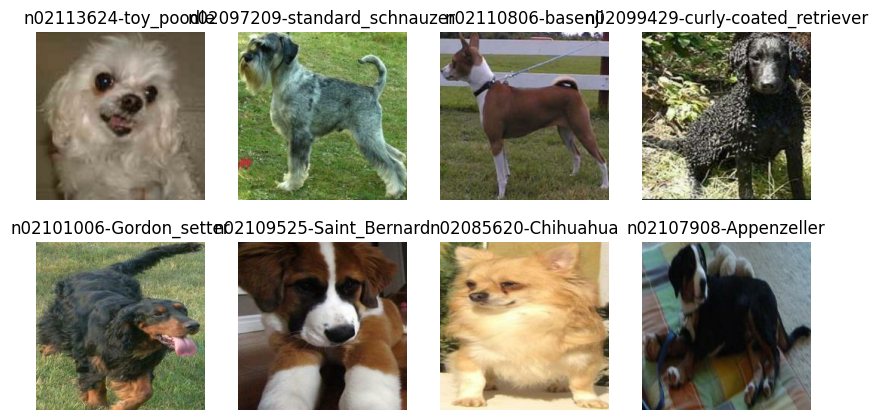

In [9]:
plt.figure(figsize=(10, 5))
for images, labels in training_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
num_classes = len(class_names)

model = keras.models.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
  keras.layers.Conv2D(128, 3, strides = (1,1), padding='valid', activation='relu', input_shape = (224, 224, 3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  Dropout(0.2),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(512, 3, padding='same', activation='leaky_relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [39]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs=50
history = model.fit(
  training_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/100
600/600 [==============================] - 491s 819ms/step - loss: 1.7566 - accuracy: 0.5603 - val_loss: 1.6725 - val_accuracy: 0.6212
Epoch 2/100
600/600 [==============================] - 490s 816ms/step - loss: 1.6989 - accuracy: 0.5731 - val_loss: 1.7718 - val_accuracy: 0.5913
Epoch 3/100
600/600 [==============================] - 489s 814ms/step - loss: 1.6972 - accuracy: 0.5840 - val_loss: 1.5750 - val_accuracy: 0.6404
Epoch 4/100
600/600 [==============================] - 489s 815ms/step - loss: 1.6972 - accuracy: 0.5776 - val_loss: 1.9741 - val_accuracy: 0.5804
Epoch 5/100
600/600 [==============================] - 489s 814ms/step - loss: 1.6689 - accuracy: 0.5872 - val_loss: 2.2552 - val_accuracy: 0.5742
Epoch 6/100
600/600 [==============================] - 489s 814ms/step - loss: 1.6579 - accuracy: 0.5973 - val_loss: 1.7086 - val_accuracy: 0.6617
Epoch 7/100
600/600 [==============================] - 489s 814ms/step - loss: 1.6294 - accuracy: 0.6028 - val_loss: 1


KeyboardInterrupt



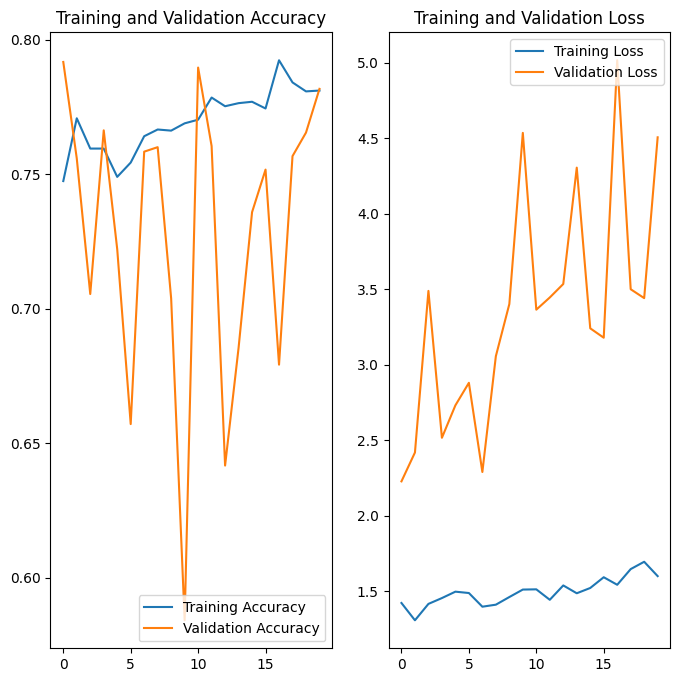

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model.evaluate(testing_ds)

269/269 [==============================] - 65s 243ms/step - loss: 6.6152 - accuracy: 0.2628


[6.615178108215332, 0.2628205120563507]

In [27]:
model.save('model19')


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c5fc0>, 140179681246336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c5fc0>, 140179681246336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c65f0>, 140179681233456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c65f0>, 140179681233456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7220>, 140179681256080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7220>, 140179681256080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7df0>, 140179681259520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7df0>, 140179681259520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e89d0>, 140179681258880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e89d0>, 140179681258880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e95a0>, 140179681258320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e95a0>, 140179681258320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ea140>, 140179680928960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ea140>, 140179680928960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ead10>, 140179680927040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ead10>, 140179680927040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003eb8b0>, 140179681253840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003eb8b0>, 140179681253840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0444c0>, 140179681260400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0444c0>, 140179681260400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045060>, 140179680935200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045060>, 140179680935200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045c30>, 140179680930000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045c30>, 140179680930000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4608, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0467d0>, 140179681247360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4608, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0467d0>, 140179681247360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0473a0>, 140179681259200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0473a0>, 140179681259200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 120), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a047f40>, 140179149965872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 120), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a047f40>, 140179149965872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(120,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0b4b50>, 140179149968752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(120,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0b4b50>, 140179149968752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c5fc0>, 140179681246336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c5fc0>, 140179681246336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c65f0>, 140179681233456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c65f0>, 140179681233456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7220>, 140179681256080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7220>, 140179681256080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7df0>, 140179681259520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003c7df0>, 140179681259520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e89d0>, 140179681258880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e89d0>, 140179681258880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e95a0>, 140179681258320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003e95a0>, 140179681258320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ea140>, 140179680928960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ea140>, 140179680928960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ead10>, 140179680927040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003ead10>, 140179680927040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003eb8b0>, 140179681253840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e003eb8b0>, 140179681253840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0444c0>, 140179681260400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0444c0>, 140179681260400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045060>, 140179680935200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045060>, 140179680935200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045c30>, 140179680930000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a045c30>, 140179680930000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4608, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0467d0>, 140179681247360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4608, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0467d0>, 140179681247360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0473a0>, 140179681259200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0473a0>, 140179681259200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 120), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a047f40>, 140179149965872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 120), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a047f40>, 140179149965872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(120,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0b4b50>, 140179149968752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(120,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7e3a0b4b50>, 140179149968752), {}).


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


In [11]:
epochs=20
history = new_model.fit(
  training_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20


2024-01-29 12:14:12.129813: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4ba56e0850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-29 12:14:12.129835: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-01-29 12:14:12.145793: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706523252.237271    4238 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 [==============================] - 292s 452ms/step - loss: 1.4206 - accuracy: 0.7474 - val_loss: 2.2264 - val_accuracy: 0.7917
Epoch 2/20
600/600 [==============================] - 272s 454ms/step - loss: 1.3060 - accuracy: 0.7707 - val_loss: 2.4176 - val_accuracy: 0.7558
Epoch 3/20
600/600 [==============================] - 278s 464ms/step - loss: 1.4145 - accuracy: 0.7595 - val_loss: 3.4883 - val_accuracy: 0.7054
Epoch 4/20
600/600 [==============================] - 283s 472ms/step - loss: 1.4532 - accuracy: 0.7595 - val_loss: 2.5151 - val_accuracy: 0.7663
Epoch 5/20
600/600 [==============================] - 329s 549ms/step - loss: 1.4956 - accuracy: 0.7490 - val_loss: 2.7302 - val_accuracy: 0.7221
Epoch 6/20
600/600 [==============================] - 363s 606ms/step - loss: 1.4866 - accuracy: 0.7543 - val_loss: 2.8793 - val_accuracy: 0.6571
Epoch 7/20
600/600 [==============================] - 433s 721ms/step - loss: 1.3960 - accuracy: 0.7641 - val_loss: 2.2885 - val_accura

In [12]:
new_model.evaluate(testing_ds)

269/269 [==============================] - 62s 231ms/step - loss: 20.0010 - accuracy: 0.2325


[20.0009765625, 0.23251748085021973]

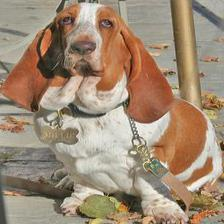

In [9]:
IMAGE_SHAPE = (224, 224)
grace_hopper = Image.open('archive/cropped/cropped/test/n02088238-basset/n02088238_600.jpg').resize(IMAGE_SHAPE)
grace_hopper

In [10]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [12]:
predicted = new_model.predict(grace_hopper[np.newaxis, ...])
predicted.shape
predicted = np.argmax(predicted, axis=1)
predicted


1/1 [==============================] - 2s 2s/step


array([104])

In [15]:
training_ds.class_names[104]

'n02111277-Newfoundland'